In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler, abc_rejection_sampler2
import seaborn as sns
from scipy.stats import norm, lognorm

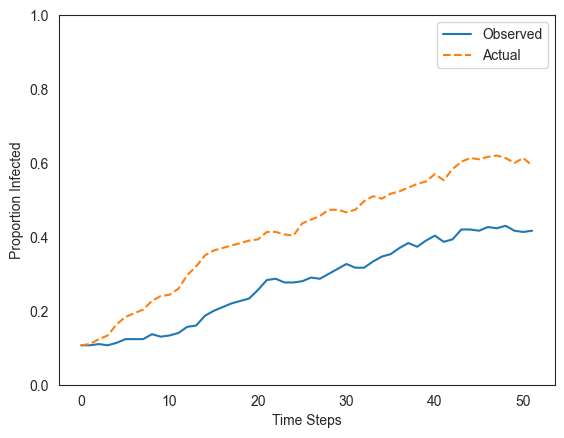

In [26]:
sns.set_style("white")

beta_true = [0.05, .1, .2, .3, .4, .5, 5]
alpha = 0.1
gamma = 0.05
eta = 0.1 # interpretation: after one week, a colonized patient will show symptoms with probability .5
heterogeneous = True
N = 300 # consider increasing
T = 52
K = 30
data_seed = 31
prior_mu = [-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]
prior_sigma = [1, 1, 1, 1, 1, 1, 1]

si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False,
                  observed_seed=data_seed, eta=eta)
y_o = si_model.get_observed_data()


si_model_alt = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False,
                  observed_seed=data_seed, eta=.999)

x_o = si_model_alt.get_observed_data()


sns.lineplot(y_o[0, :], label="Observed")
sns.lineplot(x_o[0, :], label="Actual", linestyle="--")

plt.ylim((0,1))
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/partial_obs.png")
plt.show()

In [19]:
x_o[1:6, :].mean(1)

tensor([0.3202, 0.3503, 0.4343, 0.5196, 0.4583])

In [20]:
y_o[1:6, :].mean(1)

tensor([0.2093, 0.2333, 0.3077, 0.3481, 0.2837])

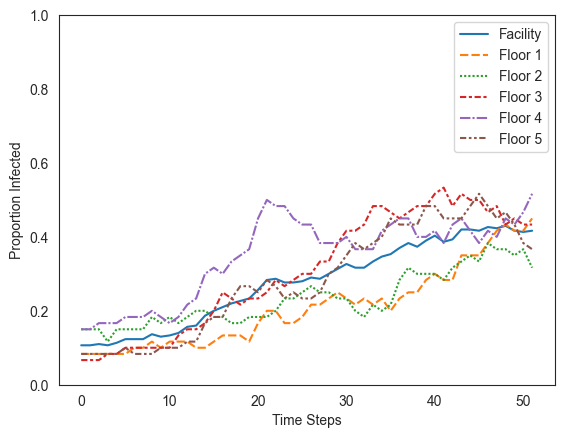

In [27]:
data = y_o[:6,:]

data = pd.DataFrame(data = data.T, columns=["Facility"] + [f"Floor {i}" for i in range(1,6)])

sns.lineplot(data)
plt.ylim((0,1))
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/partial_obs_floor_viz.png")
plt.show()

In [6]:
si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, eta_true = 0.1)
y_o = si_model.get_observed_data(29)
I_o = np.array(y_o[0])

si_model_alt = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, eta_true = 1)
y_1 = si_model_alt.get_observed_data(29)
I_1 = np.array(y_1[0])

plt.plot(I_o, label="Observed Infected")
plt.plot(I_1, label="Model Guess")
plt.legend(loc="upper right")
plt.xlabel("Time Steps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation with Partial Observation")
plt.show()

TypeError: SIModel.__init__() got an unexpected keyword argument 'eta_true'

A reasonably well-calibrated prior: $P(\beta > \beta^*) = 0.15$.

## Posterior Predictive Checks

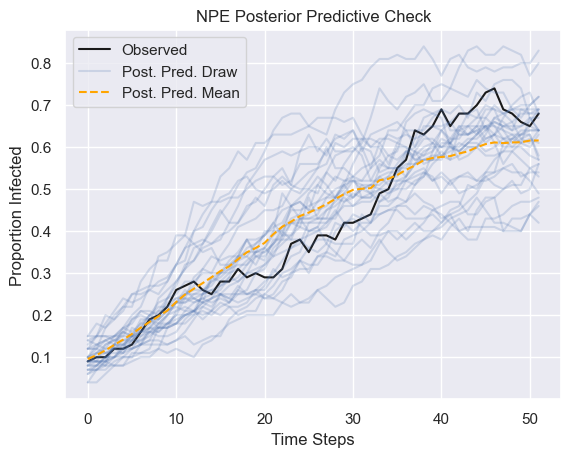

In [44]:
neural_posterior = norm(mu, sigma)
K = 30
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K, T))


for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)[0]
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("NPE Posterior Predictive Check")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

## ABC

In [65]:
# testing
eps = .01
summarize = True
si_model = SIModel(alpha, gamma, beta_true, 
                n_zones, prior_mu, prior_sigma, 
               N, T, summarize=summarize)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(29)
x_o = x_o.transpose(0, 1)
S = 100

posterior_sample, errors = abc_rejection_sampler(
    S, eps, prior_sampler, simulator, x_o, max_attempts=100000,
    summarize=summarize
    )
np.exp(posterior_sample).mean()

Time lapsed: 5.41 seconds
With tolerance 0.01, acceptance rate: 0.015810
Total number of attempts: 6,325


0.1263973

In [82]:
abc_data = {"summarize":[], "epsilon":[], "simulations":[]}
abc_samples = []

args = [(False, [5, 2, 1, 0.5, 0.4]),
        (True, [0.5, 0.2, 0.1, 0.02, 0.01])]
for summarize, es in args:
    for epsilon in es:
        si_model = SIModel(alpha, gamma, beta_true, 
                        n_zones, prior_mu, prior_sigma, 
                       N, T, summarize=summarize)
        prior_sampler = lambda: si_model.sample_logbeta(1)
        simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
        x_o = si_model.get_observed_data(29)
        x_o = x_o.transpose(0, 1)
        S = 100
        print(f"epsilon: {epsilon}")
        posterior_sample, errors = abc_rejection_sampler(
            S, epsilon, prior_sampler, simulator, x_o, max_attempts=30000,
            summarize=summarize
            )
        print("***")
        abc_data["summarize"].append(summarize)
        abc_data["epsilon"].append(epsilon)
        abc_data["simulations"].append((errors > 0).sum())
        abc_samples.append(posterior_sample[:,0])

epsilon: 5
Time lapsed: 0.11 seconds
With tolerance 5, acceptance rate: 1.000000
Total number of attempts: 100
***
epsilon: 2
Time lapsed: 0.19 seconds
With tolerance 2, acceptance rate: 0.467290
Total number of attempts: 214
***
epsilon: 1
Time lapsed: 0.54 seconds
With tolerance 1, acceptance rate: 0.158479
Total number of attempts: 631
***
epsilon: 0.5
Time lapsed: 4.38 seconds
With tolerance 0.5, acceptance rate: 0.019257
Total number of attempts: 5,193
***
epsilon: 0.4
Time lapsed: 21.03 seconds
With tolerance 0.4, acceptance rate: 0.003992
Total number of attempts: 25,053
***
epsilon: 0.5
Time lapsed: 0.08 seconds
With tolerance 0.5, acceptance rate: 1.000000
Total number of attempts: 100
***
epsilon: 0.2
Time lapsed: 0.22 seconds
With tolerance 0.2, acceptance rate: 0.386100
Total number of attempts: 259
***
epsilon: 0.1
Time lapsed: 0.57 seconds
With tolerance 0.1, acceptance rate: 0.147710
Total number of attempts: 677
***
epsilon: 0.02
Time lapsed: 2.73 seconds
With tolerance

In [149]:
df_abc = pd.DataFrame(abc_data)

abc_posterior = np.array(abc_samples)
df_abc["Posterior Mean"] = np.exp(abc_posterior).mean(1)

df_abc[".05"] = np.quantile(np.exp(abc_posterior), 0.05, 1)
df_abc[".95"] = np.quantile(np.exp(abc_posterior), 0.95, 1)
df_abc["sd"] = abc_posterior.std(1)
df_abc["mean"] = abc_posterior.mean(1)
df_abc["Method"] = df_abc["summarize"].apply(lambda x: "ABC-S" if x else "ABC")
df_abc = df_abc.rename(columns={"simulations":"Simulations"})

In [150]:
df_results = pd.concat([df_npe, 
           df_abc[["Method", "Simulations", "Posterior Mean", ".05", ".95", "mean", "sd"]]])

In [120]:
npe = df_results[df_results["Method"] == "NPE"]
abc = df_results[df_results["Method"] == "ABC"]
abcs = df_results[df_results["Method"] == "ABC-S"]

In [121]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

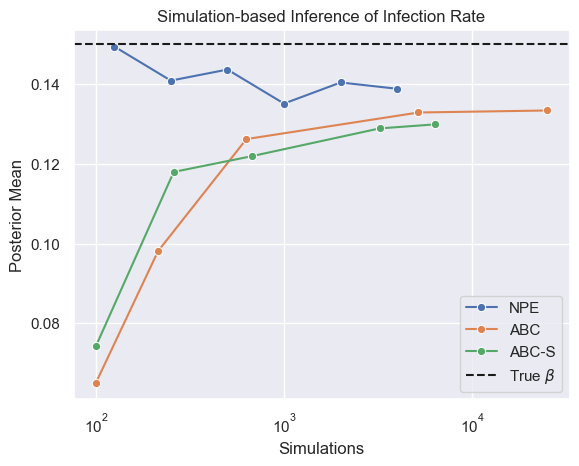

In [129]:
ax = sns.lineplot(df_results, x="Simulations", y="Posterior Mean", marker="o", hue="Method")
ax.axhline(y = 0.15, color="k", label=r"True $\beta$", linestyle="--")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Mean")
plt.title("Simulation-based Inference of Infection Rate")
plt.show()

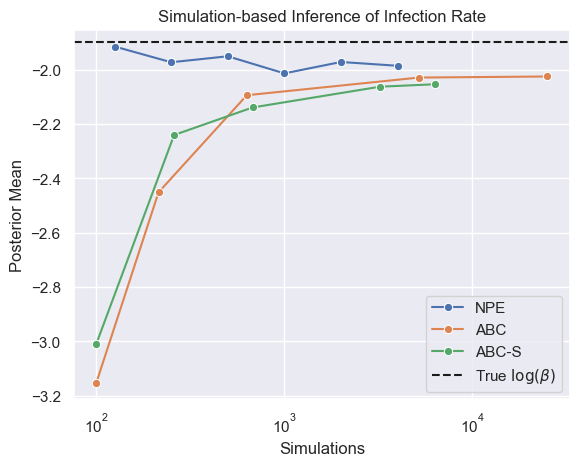

In [158]:
ax = sns.lineplot(df_results, x="Simulations", y="mean", marker="o", hue="Method")
ax.axhline(y = np.log(0.15), color="k", label=r"True $\log(\beta)$", linestyle="--")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Mean")
plt.title("Simulation-based Inference of Infection Rate")
plt.show()

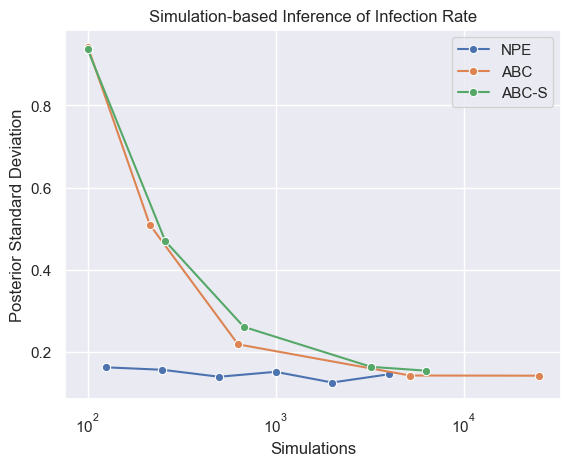

In [130]:
ax = sns.lineplot(df_results, x="Simulations", y="sd", marker="o", hue="Method")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Standard Deviation")
plt.title("Simulation-based Inference of Infection Rate")
plt.show()

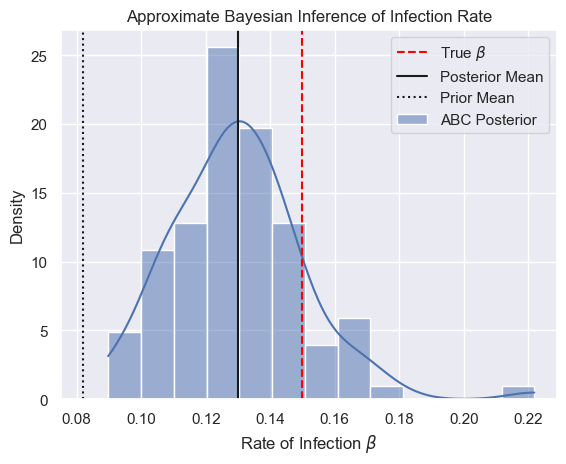

In [159]:
ax = sns.histplot(np.exp(abc_posterior[-1]), stat="density", kde=True, label="ABC Posterior")
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(r"Approximate Bayesian Inference of Infection Rate")
plt.axvline(beta_true, color="red", linestyle="--", label=r"True $\beta$")
plt.axvline(np.exp(abc_posterior[-1]).mean(), color="k", label="Posterior Mean")
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
#x.get_legend().remove()
plt.legend()
plt.show()

### ABC PPC

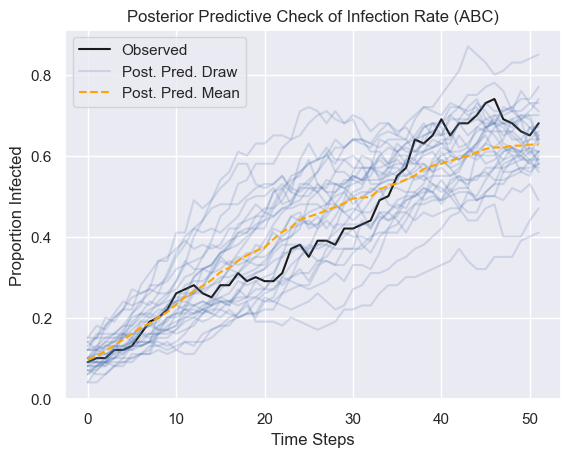

In [93]:
posterior_predictive_abc = np.empty((K, T))
for i in range(30):
    beta = np.exp(abc_posterior[-1][i])
    si_model = SIModel(alpha, gamma, beta, 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive_abc[i] =  np.array(x_rep)[0]
pp_mean_abc = posterior_predictive_abc.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive_abc.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean_abc, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate (ABC)")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

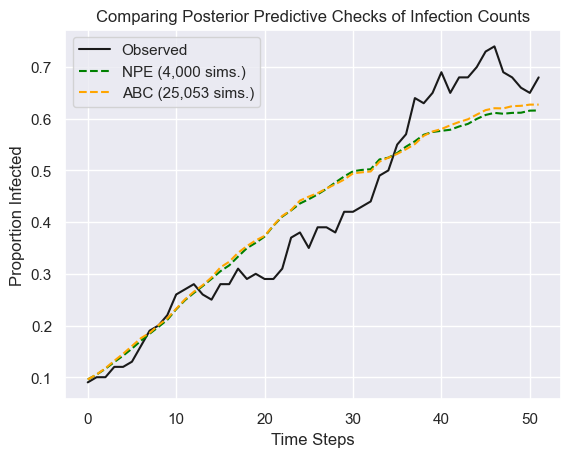

In [96]:
plt.plot(I_o, label="Observed", color="k")
plt.plot(pp_mean, label="NPE (4,000 sims.)", linestyle="--",
         color="green")
plt.plot(pp_mean_abc, label="ABC (25,053 sims.)", linestyle="--",
         color="orange")
plt.legend()
plt.title("Comparing Posterior Predictive Checks of Infection Counts")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

NPE posterior predictive mean is virtually identifical!

# Prior Strength 

In [35]:
# testing
for prior_sigma in 4,2,1,0.5,0.25:
    prior_mu = -2
    summarize = False
    si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma, 
                   N, T, summarize=summarize)
    prior_sampler = lambda: si_model.sample_logbeta(1)
    simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
    x_o = si_model.get_observed_data(29)
    S = 500
    posterior_sample, errors = abc_rejection_sampler2(S, prior_sampler, simulator, x_o, summarize)
    accepted = posterior_sample[errors.argsort()[:100]]
    print(prior_sigma)
    print(accepted.mean(), accepted.std())
    print(np.exp(accepted).mean())

4
-2.0722751998901368 0.5141953831222603
0.14268644726618598
2
-2.0503327441215515 0.287187972158015
0.13401788286858138
1
-2.0587233889102934 0.20938645858195665
0.13037059843018425
0.5
-2.006075019836426 0.1621277862643427
0.13629922818823637
0.25
-2.0318924820423128 0.12241302213547792
0.13205620046718466


In [33]:
for prior_sigma in [4,2,1,0.5,0.25]:
    prior_mu = -2
    prior_sigma = 2
    eps = 1
    summarize = False
    si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma, 
                   N, T, summarize=summarize)
    prior_sampler = lambda: si_model.sample_logbeta(1)
    simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
    x_o = si_model.get_observed_data(29)
    S = 100
    posterior_sample, errors = abc_rejection_sampler(
                S, eps, prior_sampler, simulator, x_o, max_attempts=30000,
                summarize=summarize
                )
    print(prior_sigma)
    print(posterior_sample.mean(), posterior_sample.std())
    print(np.exp(posterior_sample.mean()))

Time lapsed: 0.74 seconds
With tolerance 1, acceptance rate: 0.122549
Total number of attempts: 816
2
-2.0435112 0.2299121
0.12957296
Time lapsed: 0.79 seconds
With tolerance 1, acceptance rate: 0.109051
Total number of attempts: 917
2
-2.060451 0.20706764
0.1273965
Time lapsed: 0.71 seconds
With tolerance 1, acceptance rate: 0.120627
Total number of attempts: 829
2
-2.0888703 0.23984487
0.12382694
Time lapsed: 0.77 seconds
With tolerance 1, acceptance rate: 0.111235
Total number of attempts: 899
2
-2.0584652 0.2661679
0.12764972
Time lapsed: 0.80 seconds
With tolerance 1, acceptance rate: 0.107759
Total number of attempts: 928
2
-2.0737822 0.22720048
0.12570943
